# 15-9. 프로젝트 : 다양한 OCR모델 비교하기



- 한글 낙서에서 의미 있는 내용 추출하기로 정하고 진행했으나. 세모델 모두다 한글을 인식하지 못한다는 것을 확인하고 안습. 
- 다음과 같이 다시 주제를 변경하였음
- 영수증을 자동으로 인식하고 해당 데이터를 기반으로 자동으로 소비 지출 내역 및 자주 이용하는 가게 및 자주 사는 제품들의 개인화된 정보를 정리해 주는 앱을 개발한다는 가정하게 영수증 인식에 대한 컨셉을 잡았음

In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# STEP 1. 검증용 데이터셋 준비

In [30]:
# 이미지 불러오기
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/workplace/EX15_OCR/images/*.jpeg'))
test_filenames

['/aiffel/aiffel/workplace/EX15_OCR/images/receipt2.jpeg',
 '/aiffel/aiffel/workplace/EX15_OCR/images/receipt4.jpeg',
 '/aiffel/aiffel/workplace/EX15_OCR/images/receipt5.jpeg',
 '/aiffel/aiffel/workplace/EX15_OCR/images/receipt1.jpeg',
 '/aiffel/aiffel/workplace/EX15_OCR/images/receipt3.jpeg']

In [31]:
image_titles = []
images = []
for filename in test_filenames:
    image = cv2.imread(filename)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_titles.append(os.path.splitext(os.path.basename(filename))[0])
image_titles

['receipt2', 'receipt4', 'receipt5', 'receipt1', 'receipt3']

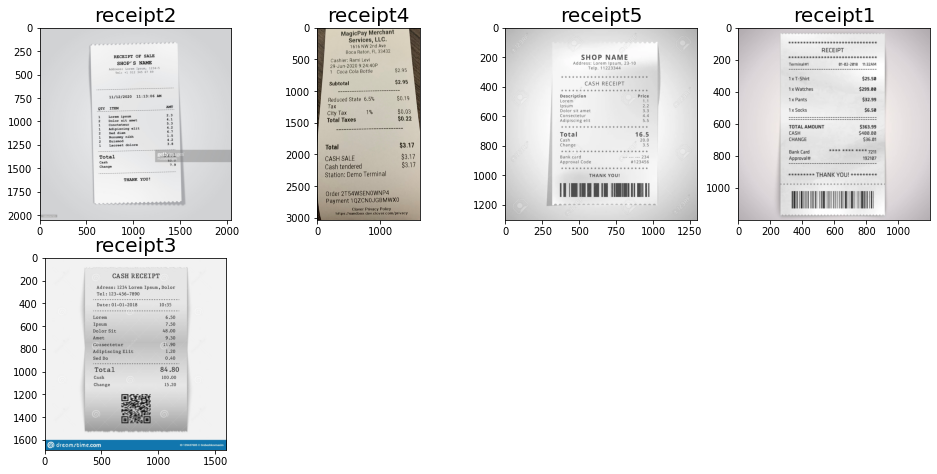

In [32]:
# 테스트 이미지 시각화
plt.figure(figsize=(16, 12))
for i, (image, title) in enumerate(zip(images, image_titles)):
    plt.subplot(3, 4, i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

# STEP 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

 ## 1. Google OCR API

### (1) 글자들의 segmentation 성능이 굉장히 좋아 보인다.


### (2) 굉장히 정확하게 글자들은 인식하고 분리해 주는 것을 확인 할 수 있다. 
- 저렇게 분리된 글자들을 사용해서 의미를 분석하고 개인정보 관리 앱을 만들 수 있을 것이라고 판단된다.  
- 특히 가격이나 물건이름 가게 이름들을 매우 높은 정확도로 분리해 내고 있는 것을 확인 할 수 있다. 
- 특수문자들의 인식이 가능하기 때문에 날짜, 시간, 통화기호 등을 정확하게 구분해 낼 수 있다.

### (3) 눈에 보이지 않는 워터마크를 인식한다.
해당 이미지들 중 이미지 스톡 에서 다운 받은 것들이 몇개 있는데 해당 이미지 스톡의 워터마크를 매우 잘 인식하는 것을 확인했다. 이것은 실험하면서 매우 신기했던 것 중에 하나다.

In [33]:
# 텍스트 탐지 함수
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [34]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

google_ocr = []

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for filenames in test_filenames:
    google_ocr.append(detect_text(filenames))

-rw-r--r-- 1 root root 2335 Feb 26 07:57 /aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"RECEIPT OF SALE
SHOP'S NAME
Address: Lorem Ipsum, 1234-5
Tel: +1 012 345 67 89
11/12/2020
11:13:06 AM
AMT
QTY
ITEM
2.3
1
Lorem ipsum
4.1
2
Dolor sit amet
5.3
1
Concteteur
4.2
Adipiscing elit
Sed diam
6.7
1.5
Nonummy nibh
Euismod
4.2
2
3.8
1
Laoreet dolore
gettyimages
Total
mustafahacalaki
40.
Cash
7.9
Change
THANK YOU!
1285504723
"

"RECEIPT"

"OF"

"SALE"

"SHOP'S"

"NAME"

"Address:"

"Lorem"

"Ipsum,"

"1234-5"

"Tel:"

"+1"

"012"

"345"

"67"

"89"

"11/12/2020"

"11:13:06"

"AM"

"AMT"

"QTY"

"ITEM"

"2.3"

"1"

"Lorem"

"ipsum"

"4.1"

"2"

"Dolor"

"sit"

"amet"

"5.3"

"1"

"Concteteur"

"4.2"

"Adipiscing"

"elit"

"Sed"

"diam"

"6.7"

"1.5"

"Nonummy"

"nibh"

"Euismod"

"4.2"

"2"

"3.8"

"1"

"Laoreet"

"dolore"

"gettyimages"

"Total"

"mustafahacalaki"

"40."

"Cash"

"7.9"

"Change"

"THANK"

"YOU!"

"1285504723"
bounds: (28,1997),(163,1999),(163,2017),(28,2015)
Texts:



## 2. keras-ocr

### (1) 글자들의 segmentation 성능은 좋아 보인다.


### (2) 가격을 정확하게 인식하기 어려움
- 통화기호인 $를 인식하지 못하고 S로 인식하는 오류가 발생하고 있다.  
- 특수문자들을 인식하지 못한다. 때문에 360.32와 같은 가격을 정확하게 인식하지 못하고 36032로 오인식하는 결과를 보여주고 있다.

### (3) 눈에 보이지 않는 워터마크를 인식한다.
해당 이미지들 중 이미지 스톡 에서 다운 받은 것들이 몇개 있는데 해당 이미지 스톡의 워터마크를 매우 잘 인식하는 것을 확인했다. 이것은 실험하면서 매우 신기했던 것 중에 하나다.

In [35]:
import keras_ocr

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [36]:
prediction_groups = [pipeline.recognize([filename]) for filename in test_filenames]

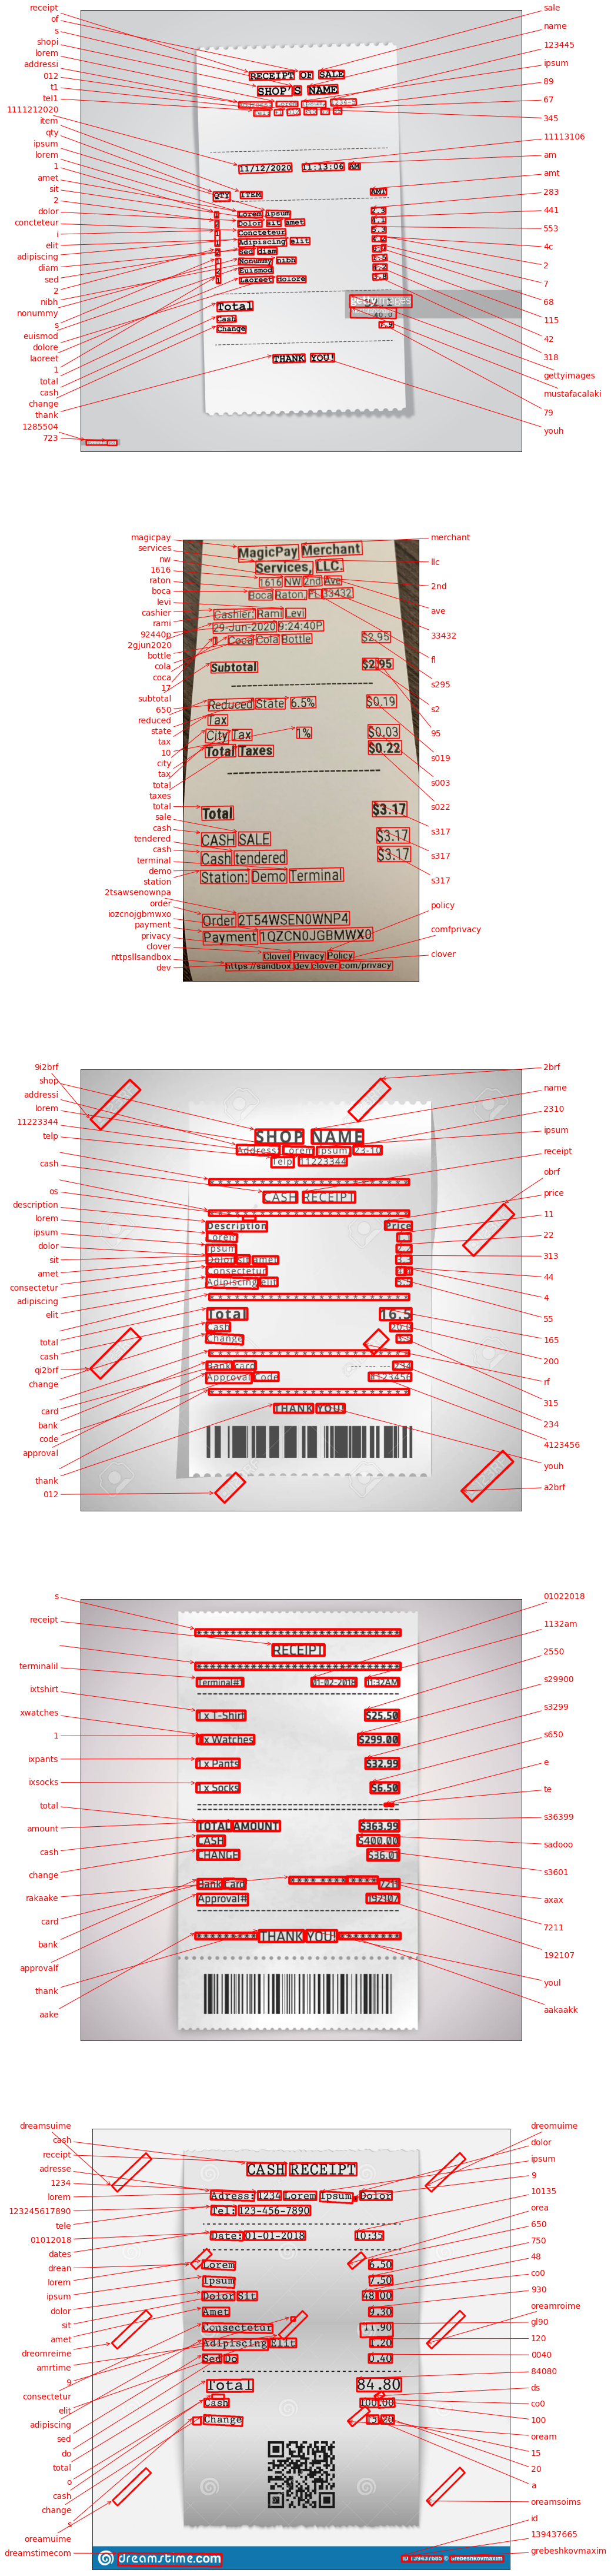

In [37]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(16, 80))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 3. Tesseract

### (1) 글자들의 segmentation 성능이 생각보다 좋지 않다.

### (2) 가격과 숫자의 인식은 비교적 정확하나 글자 인식의 정확도가 좋지 않다

In [38]:
import pytesseract
from PIL import Image
from pytesseract import Output

In [39]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

# 이미지 영역 찾는 함수
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [40]:
# 이미지에서 문자 인식하는 함수
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [41]:
# 각 이미지 별 폴더 생성하여 croped 이미지 얻기
for filename, title in zip(test_filenames, image_titles):
    work_dir = (os.path.join('./tesseract', title))
    os.makedirs(work_dir, exist_ok=True)
    cropped_image_path_list = crop_word_regions(filename, work_dir)
    recognize_images(cropped_image_path_list)

./tesseract/receipt2/0000.png
./tesseract/receipt2/0001.png
./tesseract/receipt2/0002.png
./tesseract/receipt2/0003.png
./tesseract/receipt2/0004.png
./tesseract/receipt2/0005.png
./tesseract/receipt2/0006.png
./tesseract/receipt2/0007.png
./tesseract/receipt2/0008.png
./tesseract/receipt2/0009.png
./tesseract/receipt2/0010.png
./tesseract/receipt2/0011.png
./tesseract/receipt2/0012.png
./tesseract/receipt2/0013.png
./tesseract/receipt2/0014.png
./tesseract/receipt2/0015.png
./tesseract/receipt2/0016.png
./tesseract/receipt2/0017.png
./tesseract/receipt2/0018.png
./tesseract/receipt2/0019.png
./tesseract/receipt2/0020.png
./tesseract/receipt2/0021.png
./tesseract/receipt2/0022.png
./tesseract/receipt2/0023.png
./tesseract/receipt2/0024.png
./tesseract/receipt2/0025.png
./tesseract/receipt2/0026.png
./tesseract/receipt2/0027.png
./tesseract/receipt2/0028.png
./tesseract/receipt2/0029.png
./tesseract/receipt2/0030.png
./tesseract/receipt2/0031.png
./tesseract/receipt2/0032.png
./tesserac

“Re oe

om ome

mp oe

ee oe

te

***

“oe

KH

oe

ee

RECEIPT

>

eo

ee

HK

te

ete

HH He

tee

Ht He

ee

Pe

Terminal#1

V1-Y 727-2018

11:37AM

1X

T-Shirt

$25.50

1X

Watches

$299.00

1X

Yants

$32.99

1X

Socks

$6.50

TOTAL

AMOUNT

$363.99

CASH

$400.00

CHANGE

$36.01

Rank

(ard

he ee

KERR KEE 7711

Approval#

19710/

oe oe tH

TRANK

VOU!

“fh te

**

He He He


—-— —_— a F

Done
./tesseract/receipt3/0000.png
./tesseract/receipt3/0001.png
./tesseract/receipt3/0002.png
./tesseract/receipt3/0003.png
./tesseract/receipt3/0004.png
./tesseract/receipt3/0005.png
./tesseract/receipt3/0006.png
./tesseract/receipt3/0007.png
./tesseract/receipt3/0008.png
./tesseract/receipt3/0009.png
./tesseract/receipt3/0010.png
./tesseract/receipt3/0011.png
./tesseract/receipt3/0012.png
./tesseract/receipt3/0013.png
./tesseract/receipt3/0014.png
./tesseract/receipt3/0015.png
./tesseract/receipt3/0016.png
./tesseract/receipt3/0017.pn

## 회고

- 이제는 우리주변에서 흔히 볼 수 있는 OCR이 딥러닝이었다는 것이 흥미로웠다.
- OCR에 대해서 경험 할 수 있었던 좋은 프로젝트였다.
- 한글로 테스트를 하지 못해서 아쉬움이 많이 남았다.
- 찾아 보니 네이버에서 제공하는 CLOVA OCR 이 있었지만 시간관계상 대략적인 것만 살펴 보고 직접 테스트 하지는 못했다.